# Aula 8 - SPLADE

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


## Enunciado do Exercício

Implementar a fase de indexação e buscas de um modelo sparso

Usar este modelo SPLADE já treinado naver/splade_v2_distil (do distilbert) ou splade-cocondenser-selfdistil (do BERT-base 110M params). Mais informações sobre os modelos estão neste artigo: https://arxiv.org/pdf/2205.04733.pdf
Não é necessário treinar o modelo
Avaliar nDCG@10 no TREC-COVID e comparar resultados com o BM25 e buscador denso da semana passada

A dificuldade do exercício está em implementar a função de busca e ranqueamento usada pelo SPLADE. A implementação deve ser codificada e usar implementação do SPLADE apenas para comparação. A implementação do índice invertido é apenas um "dicionário python".

Fazer a comparação dos seus resultados com a busca "original" do SPLADE.
Medir latência (s/query)



# Organizando o ambiente

In [2]:
import pickle

In [3]:
import math

In [4]:
import os

In [ ]:
import matplotlib.pyplot as plt

In [5]:
import gzip

In [228]:
import statistics


In [162]:
import time

In [6]:
import json

In [7]:
import pandas as pd

In [8]:
from tqdm import tqdm

In [9]:
from transformers import  BatchEncoding

/home/borela/miniconda3/envs/treinapython39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from torch.nn.functional import relu

In [11]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

In [12]:
from evaluate import load

In [13]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/splade'
DIRETORIO_TREC_COVID = F'{DIRETORIO_LOCAL}/trec_covid'

In [14]:
if os.path.exists(DIRETORIO_LOCAL):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_LOCAL)
    print('pasta criada!')


pasta já existia!


In [15]:
if os.path.exists(DIRETORIO_TRABALHO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TRABALHO)
    print('pasta criada!')


pasta já existia!


In [16]:
if os.path.exists(DIRETORIO_TREC_COVID):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TREC_COVID)
    print('pasta criada!')


pasta já existia!


In [17]:
DIRETORIO_RUN = f"{DIRETORIO_TRABALHO}/runs"
CAMINHO_RUN = f"{DIRETORIO_RUN}/run-trec-covid-bm25.txt"

In [18]:
if os.path.exists(DIRETORIO_RUN):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_RUN)
    print('pasta criada!')


pasta já existia!


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  

In [20]:
from psutil import virtual_memory

In [21]:
def mostra_memoria(lista_mem=['cpu']):
  """
  Esta função exibe informações de memória da CPU e/ou GPU, conforme parâmetros fornecidos.

  Parâmetros:
  -----------
  lista_mem : list, opcional
      Lista com strings 'cpu' e/ou 'gpu'. 
      'cpu' - exibe informações de memória da CPU.
      'gpu' - exibe informações de memória da GPU (se disponível).
      O valor padrão é ['cpu'].

  Saída:
  -------
  A função não retorna nada, apenas exibe as informações na tela.

  Exemplo de uso:
  ---------------
  Para exibir informações de memória da CPU:
      mostra_memoria(['cpu'])

  Para exibir informações de memória da CPU e GPU:
      mostra_memoria(['cpu', 'gpu'])
  
  Autor: Marcus Vinícius Borela de Castro

  """  
  if 'cpu' in lista_mem:
    vm = virtual_memory()
    ram={}
    ram['total']=round(vm.total / 1e9,2)
    ram['available']=round(virtual_memory().available / 1e9,2)
    # ram['percent']=round(virtual_memory().percent / 1e9,2)
    ram['used']=round(virtual_memory().used / 1e9,2)
    ram['free']=round(virtual_memory().free / 1e9,2)
    ram['active']=round(virtual_memory().active / 1e9,2)
    ram['inactive']=round(virtual_memory().inactive / 1e9,2)
    ram['buffers']=round(virtual_memory().buffers / 1e9,2)
    ram['cached']=round(virtual_memory().cached/1e9 ,2)
    print(f"Your runtime RAM in gb: \n total {ram['total']}\n available {ram['available']}\n used {ram['used']}\n free {ram['free']}\n cached {ram['cached']}\n buffers {ram['buffers']}")
    print('/nGPU')
    gpu_info = !nvidia-smi
  if 'gpu' in lista_mem:
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)


In [35]:
mostra_memoria(['cpu','gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 45.85
 used 20.2
 free 26.8
 cached 19.02
 buffers 1.34
/nGPU
Sun Apr 23 16:17:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 59%   45C    P8    30W / 370W |  11513MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

## Fixando as seeds

In [23]:
import random
import torch
import numpy as np

In [24]:
def inicializa_seed(num_semente:int=123):
  """
  Inicializa as sementes para garantir a reprodutibilidade dos resultados do modelo.
  Essa é uma prática recomendada, já que a geração de números aleatórios pode influenciar os resultados do modelo.
  Além disso, a função também configura as sementes da GPU para garantir a reprodutibilidade quando se utiliza aceleração por GPU. 
  
  Args:
      num_semente (int): número da semente a ser utilizada para inicializar as sementes das bibliotecas.
  
  References:
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  # Define as sementes das bibliotecas random, numpy e pytorch
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  
  # Define as sementes da GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True


In [25]:
num_semente=123
inicializa_seed(num_semente)

## Preparando para debug e display

In [26]:
import pandas as pd

In [27]:
import transformers

In [28]:
# https://zohaib.me/debugging-in-google-collab-notebook/
# !pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção
# ipdb.set_trace(context=8)  para execução nesse ponto

In [29]:
def config_display():
  """
  Esta função configura as opções de display do Pandas.
  """

  # Configurando formato saída Pandas
  # define o número máximo de colunas que serão exibidas
  pd.options.display.max_columns = None

  # define a largura máxima de uma linha
  pd.options.display.width = 1000

  # define o número máximo de linhas que serão exibidas
  pd.options.display.max_rows = 100

  # define o número máximo de caracteres por coluna
  pd.options.display.max_colwidth = 50

  # se deve exibir o número de linhas e colunas de um DataFrame.
  pd.options.display.show_dimensions = True

  # número de dígitos após a vírgula decimal a serem exibidos para floats.
  pd.options.display.precision = 7


In [30]:
def config_debug():
  """
  Esta função configura as opções de debug do PyTorch e dos pacotes
  transformers e datasets.
  """

  # Define opções de impressão de tensores para o modo científico
  torch.set_printoptions(sci_mode=True) 
  """
    Significa que valores muito grandes ou muito pequenos são mostrados em notação científica.
    Por exemplo, em vez de imprimir o número 0.0000012345 como 0.0000012345, 
    ele seria impresso como 1.2345e-06. Isso é útil em situações em que os valores dos tensores 
    envolvidos nas operações são muito grandes ou pequenos, e a notação científica permite 
    uma melhor compreensão dos números envolvidos.  
  """

  # Habilita detecção de anomalias no autograd do PyTorch
  torch.autograd.set_detect_anomaly(True)
  """
    Permite identificar operações que podem causar problemas de estabilidade numérica, 
    como gradientes explodindo ou desaparecendo. Quando essa opção é ativada, 
    o PyTorch verifica se há operações que geram valores NaN ou infinitos nos tensores 
    envolvidos no cálculo do gradiente. Se for detectado um valor anômalo, o PyTorch 
    interrompe a execução e gera uma exceção, permitindo que o erro seja corrigido 
    antes que se torne um problema maior.

    É importante notar que a detecção de anomalias pode ter um impacto significativo 
    no desempenho, especialmente em modelos grandes e complexos. Por esse motivo,
    ela deve ser usada com cautela e apenas para depuração.
  """

  # Configura variável de ambiente para habilitar a execução síncrona (bloqueante) das chamadas da API do CUDA.
  os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  """
    o Python aguarda o término da execução de uma chamada da API do CUDA antes de executar a próxima chamada. 
    Isso é útil para depurar erros no código que envolve operações na GPU, pois permite que o erro seja capturado 
    no momento em que ocorre, e não depois de uma sequência de operações que pode tornar a origem do erro mais difícil de determinar.
    No entanto, é importante lembrar que esse modo de execução é significativamente mais lento do que a execução assíncrona, 
    que é o comportamento padrão do CUDA. Por isso, é recomendado utilizar esse comando apenas em situações de depuração 
    e removê-lo após a solução do problema.
  """

  # Define o nível de verbosity do pacote transformers para info
  # transformers.utils.logging.set_verbosity_info() 
  
  
  """
    Define o nível de detalhamento das mensagens de log geradas pela biblioteca Hugging Face Transformers 
    para o nível info. Isso significa que a biblioteca irá imprimir mensagens de log informativas sobre
    o andamento da execução, tais como tempo de execução, tamanho de batches, etc.

    Essas informações podem ser úteis para entender o que está acontecendo durante a execução da tarefa 
    e auxiliar no processo de debug. É importante notar que, em alguns casos, a quantidade de informações
    geradas pode ser muito grande, o que pode afetar o desempenho do sistema e dificultar a visualização
    das informações relevantes. Por isso, é importante ajustar o nível de detalhamento de acordo com a 
    necessidade de cada tarefa.
  
    Caso queira reduzir a quantidade de mensagens, comentar a linha acima e 
      descomentar as duas linhas abaixo, para definir o nível de verbosity como error ou warning
  
    transformers.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_warning()
  """


  # Define o modo verbose do xmode, que é utilizado no debug
  # %xmode Verbose 

  """
    Comando usado no Jupyter Notebook para controlar o modo de exibição das informações de exceções.
    O modo verbose é um modo detalhado que exibe informações adicionais ao imprimir as exceções.
    Ele inclui as informações de pilha de chamadas completa e valores de variáveis locais e globais 
    no momento da exceção. Isso pode ser útil para depurar e encontrar a causa de exceções em seu código.
    Ao usar %xmode Verbose, as informações de exceção serão impressas com mais detalhes e informações adicionais serão incluídas.

    Caso queira desabilitar o modo verbose e utilizar o modo plain, 
    comentar a linha acima e descomentar a linha abaixo:
    %xmode Plain
  """

  """
    Dica:
    1.  pdb (Python Debugger)
      Quando ocorre uma exceção em uma parte do código, o programa para a execução e exibe uma mensagem de erro 
      com informações sobre a exceção, como a linha do código em que ocorreu o erro e o tipo da exceção.

      Se você estiver depurando o código e quiser examinar o estado das variáveis ​​e executar outras operações 
      no momento em que a exceção ocorreu, pode usar o pdb (Python Debugger). Para isso, é preciso colocar o comando %debug 
      logo após ocorrer a exceção. Isso fará com que o programa pare na linha em que ocorreu a exceção e abra o pdb,
      permitindo que você explore o estado das variáveis, examine a pilha de chamadas e execute outras operações para depurar o código.


    2. ipdb
      O ipdb é um depurador interativo para o Python que oferece recursos mais avançados do que o pdb,
      incluindo a capacidade de navegar pelo código fonte enquanto depura.
      
      Você pode começar a depurar seu código inserindo o comando ipdb.set_trace() em qualquer lugar do 
      seu código onde deseja pausar a execução e começar a depurar. Quando a execução chegar nessa linha, 
      o depurador entrará em ação, permitindo que você examine o estado atual do seu programa e execute 
      comandos para investigar o comportamento.

      Durante a depuração, você pode usar comandos:
        next (para executar a próxima linha de código), 
        step (para entrar em uma função chamada na próxima linha de código) 
        continue (para continuar a execução normalmente até o próximo ponto de interrupção).

      Ao contrário do pdb, o ipdb é um depurador interativo que permite navegar pelo código fonte em que
      está trabalhando enquanto depura, permitindo que você inspecione variáveis, defina pontos de interrupção
      adicionais e até mesmo execute expressões Python no contexto do seu programa.
  """


In [31]:
config_display()

In [32]:
config_debug()

# Baixando o dataset para avaliação (trec-covid)

## Queries

In [39]:
os.environ['JVM_PATH'] = '/usr/lib/jvm/java-11-openjdk-amd64/lib/server/libjvm.so'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

In [40]:
from pyserini.search import get_topics

In [41]:
topics = get_topics('covid-round5')
print(f'{len(topics)} queries total')

50 queries total


In [42]:
topics[50]

{'question': 'what is known about an mRNA vaccine for the SARS-CoV-2 virus?',
 'query': 'mRNA vaccine coronavirus',
 'narrative': 'Looking for studies specifically focusing on mRNA vaccines for COVID-19, including how mRNA vaccines work, why they are promising, and any results from actual clinical studies.'}

## Relevância (qrel) de teste

In [43]:
if not os.path.exists(f'{DIRETORIO_TREC_COVID}/test.tsv'):
    !wget https://huggingface.co/datasets/BeIR/trec-covid-qrels/raw/main/test.tsv
    !mv test.tsv {DIRETORIO_LOCAL}/
else:
    print('Arquivo já existia')

Arquivo já existia


In [44]:
qrel = pd.read_csv(f"{DIRETORIO_TREC_COVID}/test.tsv", sep="\t", header=None, 
                   skiprows=1, names=["query", "docid", "rel"])

In [45]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [46]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [47]:
qrel["q0"] = "q0"
qrel_dict = qrel.to_dict(orient="list")

In [48]:
qrel_dict['query'][0], qrel_dict['docid'][0], qrel_dict['rel'][0]

(1, '005b2j4b', 2)

## Documentos a serem indexados

In [49]:
if not os.path.exists(f"{DIRETORIO_TREC_COVID}/corpus.jsonl.gz"):
    !wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
    !mv corpus.jsonl.gz {DIRETORIO_TREC_COVID}
    print('Baixado')
else:
    print('Já existia a pasta')

Já existia a pasta


In [50]:
# Descompacte o arquivo para a memória
with gzip.open(f'{DIRETORIO_TREC_COVID}/corpus.jsonl.gz', 'rt') as f:
    # Leia o conteúdo do arquivo descompactado
    corpus = [json.loads(line) for line in f]

In [51]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} corpus[0] {corpus[0]}" )

<class 'list'> len(corpus): 171332 corpus[0] {'_id': 'ug7v899j', 'title': 'Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia', 'text': 'OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%

In [52]:
corpus[0].keys()

dict_keys(['_id', 'title', 'text', 'metadata'])

In [53]:
lista_doc_id_passage = [doc['_id'] for doc in corpus]
print(f"len(lista_doc_id_passage) {len(lista_doc_id_passage)}")

len(lista_doc_id_passage) 171332


# Experimentos de teste de encoding

## Com modelo 'naver/splade-cocondenser-ensembledistil' 

In [54]:
PATH_NOME_MODELO = "naver/splade-cocondenser-ensembledistil"

In [55]:
# Se tiver que treinar os modelos, abre
model = BertForMaskedLM.from_pretrained(PATH_NOME_MODELO).to(device)

In [56]:
print(model.config)

BertConfig {
  "_name_or_path": "naver/splade-cocondenser-ensembledistil",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [59]:
tokenizer = BertTokenizer.from_pretrained(PATH_NOME_MODELO)

In [60]:
print(tokenizer.model_max_length)

512


In [61]:
sentences_test = ["He likes to eat pizza in the pizza hut.", "So many sentences are transformed in just a summary."]

In [62]:
    # Tokenize sentences
encoded_input = tokenizer(sentences_test,
                                add_special_tokens=True,
                                return_special_tokens_mask=True, 
                                padding=True, 
                                truncation=True,
                                max_length=model.config.max_position_embeddings,
                                return_tensors='pt')

In [63]:
print(encoded_input)

{'input_ids': tensor([[  101,  2002,  7777,  2000,  4521, 10733,  1999,  1996, 10733, 12570,
          1012,   102],
        [  101,  2061,  2116, 11746,  2024,  8590,  1999,  2074,  1037, 12654,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [64]:
# print(f"padded_batch {padded_batch}")
encoded_input = BatchEncoding(encoded_input)
print('após BatchEncoding',encoded_input)

após BatchEncoding {'input_ids': tensor([[  101,  2002,  7777,  2000,  4521, 10733,  1999,  1996, 10733, 12570,
          1012,   102],
        [  101,  2061,  2116, 11746,  2024,  8590,  1999,  2074,  1037, 12654,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [65]:
encoded_input['input_ids'].shape[1]

12

In [66]:
# Move os dados para o dispositivo especificado (CPU ou GPU)
encoded_input_cuda = {key: value.to(device) for key, value in encoded_input.items()}
print(encoded_input)

{'input_ids': tensor([[  101,  2002,  7777,  2000,  4521, 10733,  1999,  1996, 10733, 12570,
          1012,   102],
        [  101,  2061,  2116, 11746,  2024,  8590,  1999,  2074,  1037, 12654,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [67]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**{k:v for k,v in encoded_input_cuda.items() if k != 'special_tokens_mask'})

In [68]:
model_output.keys()

odict_keys(['logits'])

In [69]:
model_output.logits.shape

torch.Size([2, 12, 30522])

In [70]:
logits = model_output.logits.cpu()

In [71]:
assert logits.shape[0]== len(sentences_test), f"logits.shape[0] deveria ser igual a len(sentences_test), mas {logits.shape[0]} != {len(sentences_test)}"

In [72]:
assert logits.shape[2]== model.config.vocab_size, f"logits.shape[2] deveria ser igual model.config.vocab_size, mas {logits.shape[2]} != {model.config.vocab_size}  "

In [73]:
assert logits.shape[1] ==  encoded_input['input_ids'].shape[1], f"logits.shape[1] ==  encoded_input['input_ids'].shape[1], mas {logits.shape[1]} != {encoded_input['input_ids'].shape[1]}"

In [74]:
logits

tensor([[[-6.3893e+00, -8.2711e+00, -7.5464e+00,  ..., -8.2343e+00, -7.9853e+00, -6.5540e+00],
         [-1.0677e+01, -1.0912e+01, -1.0080e+01,  ..., -1.1239e+01, -1.0584e+01, -1.0340e+01],
         [-1.4504e+01, -1.3984e+01, -1.2138e+01,  ..., -1.3341e+01, -1.2841e+01, -1.3440e+01],
         ...,
         [-1.1762e+01, -1.0844e+01, -9.7184e+00,  ..., -1.0512e+01, -9.5783e+00, -1.1487e+01],
         [-2.0236e+01, -1.6708e+01, -1.5875e+01,  ..., -1.6253e+01, -1.5220e+01, -1.7133e+01],
         [-1.8771e+01, -1.5834e+01, -1.5056e+01,  ..., -1.5429e+01, -1.4388e+01, -1.6011e+01]],

        [[-6.0462e+00, -8.0102e+00, -7.5297e+00,  ..., -7.4065e+00, -7.7055e+00, -6.0488e+00],
         [-7.0161e+00, -8.8562e+00, -8.1384e+00,  ..., -8.3108e+00, -8.6692e+00, -6.5108e+00],
         [-9.4267e+00, -1.0151e+01, -9.3825e+00,  ..., -9.5120e+00, -9.9987e+00, -7.8468e+00],
         ...,
         [-2.0250e+01, -1.6809e+01, -1.7290e+01,  ..., -1.6032e+01, -1.6992e+01, -1.9700e+01],
         [-1.8281e+0

In [75]:
logits_relu = relu(logits)

In [76]:
logits_relu.shape

torch.Size([2, 12, 30522])

In [77]:
indices_nao_zero = torch.nonzero(logits_relu)

In [78]:
indices_nao_zero.shape

torch.Size([248, 3])

In [79]:
for i in range(logits_relu.shape[0]):
    indices = indices_nao_zero[i]
    print(f"Indices não nulos para a amostra {i}:")
    print(indices)

Indices não nulos para a amostra 0:
tensor([   0,    0, 2002])
Indices não nulos para a amostra 1:
tensor([   0,    0, 2010])


In [80]:
print(indices_nao_zero[:3])

tensor([[   0,    0, 2002],
        [   0,    0, 2010],
        [   0,    0, 2032]])


In [81]:

num_splits = 2  # dividir indices_nao_zero em duas partes
batch_size = indices_nao_zero.shape[0] // num_splits  # indices_nao_zero.shape[0]

splits = torch.split(indices_nao_zero, batch_size, dim=0)

for i, split in enumerate(splits):
    # encontre os valores não-zero correspondentes em logits_relu para esta parte de indices_nao_zero
    values = logits_relu[split[:, 0], split[:, 1], split[:, 2]]
    print(f"Valores para a parte {i}: {values[:3]}")

Valores para a parte 0: tensor([1.4559e+00, 9.9054e-01, 6.2091e-01])
Valores para a parte 1: tensor([1.2144e+00, 2.6016e-01, 3.4094e-02])


In [82]:
valores = logits_relu[indices_nao_zero[:, 0], indices_nao_zero[:, 1], indices_nao_zero[:, 2]]

In [83]:
print(valores.shape, valores[:3])

torch.Size([248]) tensor([1.4559e+00, 9.9054e-01, 6.2091e-01])


## Usando "sum"

In [84]:
wj_sum = torch.sum(torch.log(1 + relu(logits)), dim=1)

In [85]:
wj_sum.shape

torch.Size([2, 30522])

In [86]:
wj_sum_sparse = wj_sum.to_sparse()

In [87]:
type(wj_sum_sparse), wj_sum_sparse.shape

(torch.Tensor, torch.Size([2, 30522]))

In [88]:
wj_sum_sparse

tensor(indices=tensor([[    0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     1,     1,
                            1,     1,     1,     1,     1,     1,     1,     1,
                            1,     1,     1,     1,     1,     1,     1,     1,
                            1,     1,     1,     1,     1,     1,     1,     1,
                            1,     1,   

In [89]:
wj_sum_sparse._values().shape, wj_sum_sparse._values().sum()

(torch.Size([123]), tensor(9.5482e+01))

## Compreendendo tensor esparso

In [90]:
wj_sum_sparse._indices().shape


torch.Size([2, 123])

In [91]:
print(f"Número de subwords/tokens de entrada: {wj_sum_sparse._indices()[0].max() + 1}")

Número de subwords/tokens de entrada: 2


In [92]:
print(f"Qtd de elementos no vetor esparso: {wj_sum_sparse._nnz()}")

Qtd de elementos no vetor esparso: 123


In [93]:
wj_sum_sparse.element_size(), wj_sum_sparse.sparse_dim(), wj_sum_sparse.numel(), wj_sum_sparse._nnz()

(4, 2, 61044, 123)

### Visualizando economia de espaço

In [94]:
mem_vetor_esparso = wj_sum_sparse.element_size() * wj_sum_sparse._nnz()  # calcula o tamanho em bytes do tensor esparso

In [95]:
mem_vetor_contiguo = wj_sum.element_size() * wj_sum.numel()  # calcula o tamanho em bytes do tensor esparso

In [96]:
print(f"Memória vetor esparso {mem_vetor_esparso} x contíguo {mem_vetor_contiguo} {round(100*mem_vetor_esparso/mem_vetor_contiguo,3)}%")

Memória vetor esparso 492 x contíguo 244176 0.201%


In [97]:
# t = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6]])

unique_vals, counts = torch.unique(wj_sum_sparse._indices()[0], return_counts=True)

In [98]:
counts_dict = {val.item(): count.item() for val, count in zip(unique_vals, counts)}


In [99]:
print(counts_dict)

{0: 70, 1: 53}


In [100]:
values_dict = {}
unique_indices = torch.unique(wj_sum_sparse._indices()[0])
for idx in unique_indices:
    values_dict[idx.item()] = wj_sum_sparse._indices()[1][wj_sum_sparse._indices()[0] == idx].tolist()


In [101]:
print(values_dict)

{0: [1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782], 1: [1999, 2061, 2062, 2074, 2116, 2205, 2261, 2338, 2411, 2466, 2561, 2671, 2726, 2773, 2878, 2904, 3191, 3213, 3365, 3375, 3432, 3674, 3722, 3752, 3793, 3975, 4471, 4489, 4706, 4800, 4807, 5290, 5449, 5530, 6251, 6310, 6412, 6796, 7063, 7065, 7680, 8553, 8590, 8651, 9185, 9491, 10938, 11091, 11746, 12654, 14686, 20423, 21743]}


In [102]:
for pos, list_tokens in values_dict.items():
    print(f"pos {pos}:{sentences_test[pos]}")
    print(f"{list_tokens}")
    print(f"{tokenizer.convert_ids_to_tokens(list_tokens)} ")

# tokenizer.convert_ids_to_tokens(wj_sparse._indices()[1])

pos 0:He likes to eat pizza in the pizza hut.
[1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782]
['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald

## Usando "max"

In [103]:
wj_max, _ = torch.max(torch.log(1 + relu(logits)), dim=1)

In [104]:
wj_max_sparse = wj_max.to_sparse()

In [105]:
wj_max_sparse.shape

torch.Size([2, 30522])

In [106]:
# t = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6]])
unique_vals, counts = torch.unique(wj_max_sparse._indices()[0], return_counts=True)
counts_dict = {val.item(): count.item() for val, count in zip(unique_vals, counts)}
print(counts_dict)

{0: 70, 1: 53}


In [107]:
values_dict = {}
unique_indices = torch.unique(wj_max_sparse._indices()[0])
for idx in unique_indices:
    values_dict[idx.item()] = wj_max_sparse._indices()[1][wj_max_sparse._indices()[0] == idx].tolist()


In [108]:
print(values_dict)

{0: [1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782], 1: [1999, 2061, 2062, 2074, 2116, 2205, 2261, 2338, 2411, 2466, 2561, 2671, 2726, 2773, 2878, 2904, 3191, 3213, 3365, 3375, 3432, 3674, 3722, 3752, 3793, 3975, 4471, 4489, 4706, 4800, 4807, 5290, 5449, 5530, 6251, 6310, 6412, 6796, 7063, 7065, 7680, 8553, 8590, 8651, 9185, 9491, 10938, 11091, 11746, 12654, 14686, 20423, 21743]}


In [109]:
for pos, list_tokens in values_dict.items():
    print(f"pos {pos}:{sentences_test[pos]}")
    print(f"{list_tokens}")
    print(f"{tokenizer.convert_ids_to_tokens(list_tokens)} ")

# tokenizer.convert_ids_to_tokens(wj_sparse._indices()[1])

pos 0:He likes to eat pizza in the pizza hut.
[1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782]
['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald

In [110]:
wj_max_sparse._values().sum(), wj_sum_sparse._values().sum()

(tensor(5.4646e+01), tensor(9.5482e+01))

## Conclusão dos experimentos


As expansões se equivalem, seja usando max ou sum, pois as 123 tokens (após expansão) são as 123 não zeradas do logits (após relu).
O que muda são os valores dos scores das tokens, o que pode influenciar na busca (sum:95, max:54)


# Funções auxiliares

In [111]:
def retorna_subword_importante(
    parm_model: BertForMaskedLM,
    parm_tokenizer: BertTokenizer,
    parm_sentences: list,
    parm_ind_agg: str = 'max'
  )  -> torch.sparse.FloatTensor:
    """
    Retorna um tensor esparso contendo as subpalavras importantes de cada sentença fornecida.

    Args:
        parm_model (BertForMaskedLM): O modelo pré-treinado utilizado para geração de embeddings.
        parm_tokenizer (BertTokenizer): O tokenizador associado ao modelo pré-treinado.
        parm_sentences (list): A lista de sentenças para as quais se deseja obter as subpalavras importantes.
        parm_ind_agg (str): O método de agregação de índices para geração do tensor esparso. As opções são:
                                            - 'max': para agregar índices por meio do valor máximo naquela posição;
                                            - 'sum': para agregar índices por meio da soma naquela posição.

    Returns:
        torch.sparse.FloatTensor: O tensor esparso com as subpalavras importantes de cada sentença.
    """
    encoded_input = parm_tokenizer(parm_sentences,
                                    add_special_tokens=True,
                                    return_special_tokens_mask=True, 
                                    padding=True, 
                                    truncation=True,
                                    max_length=model.config.max_position_embeddings,
                                    return_tensors='pt')



    encoded_input = BatchEncoding(encoded_input)
    encoded_input_cuda = {key: value.to(device) for key, value in encoded_input.items()}
    with torch.no_grad():
        model_output = parm_model(**{k:v for k,v in encoded_input_cuda.items() if k != 'special_tokens_mask'})
    logits = model_output.logits.cpu()    
    assert logits.shape[0]== len(parm_sentences), f"logits.shape[0] deveria ser igual a len(sentences_test), mas {logits.shape[0]} != {len(sentences_test)}"
    assert logits.shape[2]== model.config.vocab_size, f"logits.shape[2] deveria ser igual model.config.vocab_size, mas {logits.shape[2]} != {model.config.vocab_size}  "
    assert logits.shape[1] ==  encoded_input['input_ids'].shape[1], f"logits.shape[1] ==  encoded_input['input_ids'].shape[1], mas {logits.shape[1]} != {encoded_input['input_ids'].shape[1]}"
    # print(f"model_output.logits.shape {model_output.logits.shape}")
    if parm_ind_agg == 'max':
        wj, _ = torch.max(torch.log(1 + relu(logits)), dim=1)
    elif parm_ind_agg == 'sum':
        wj = torch.sum(torch.log(1 + relu(logits)), dim=1)
    else:
        raise Exception(f"parm_ind_aggregation_method deve ser 'max' ou 'sum', mas passado {parm_ind_aggregation_method}!")
    
    return wj.to_sparse()


torch.Size([1024, 30522])

In [ ]:
def retorna_tokens_expansao(parm_expansao: torch.Tensor, 
                            parm_tokenizer: BertTokenizer,
                            parm_sentences: list) -> dict:
    """
    Retorna um dicionário com informações sobre as expansões de tokens para cada sentença.

    Args:
        parm_expansao (torch.Tensor): Tensor esparso com as expansões de tokens.
        parm_tokenizer (BertTokenizer): Tokenizer associado ao modelo BERT utilizado nas expansões.
        parm_sentences (list): Lista de sentenças utilizadas para gerar as expansões.

    Returns:
        dict: Dicionário com informações sobre as expansões de tokens para cada sentença. Cada item do dicionário
        contém as seguintes chaves:
        - 'text': A sentença original.
        - 'list_tokens_expanded': Uma lista de tokens correspondente às expansões geradas para a sentença.
    """
    # Verifica se o número de linhas da expansão é igual ao número de sentenças
    assert parm_expansao.shape[0] == len(parm_sentences), f"parm_expansao.shape[0] == len(parm_sentences), mas {parm_expansao.shape[0]} != {len(parm_sentences)}"

    # Cria um dicionário para armazenar os valores únicos presentes na expansão
    values_dict = {}
    # Obtém os índices únicos da expansão
    unique_indices = torch.unique(parm_expansao._indices()[0])
    # Para cada índice único, armazena a lista de tokens correspondente
    for idx in unique_indices:
        values_dict[idx.item()] = parm_expansao._indices()[1][parm_expansao._indices()[0] == idx].tolist()

    # Cria um dicionário de retorno com as informações de cada sentença
    dict_retorno = {}
    for pos, list_tokens in values_dict.items():
        dict_retorno[pos] = {'text': parm_sentences[pos], 
                             'list_tokens_expanded': parm_tokenizer.convert_ids_to_tokens(list_tokens)}
    return dict_retorno


In [ ]:
def expande_corpus(parm_model:BertForMaskedLM,
                   parm_tokenizer:BertTokenizer, 
                   parm_sentences:list,
                   parm_batch_size:int=64,
                   parm_ind_agg:str='max') -> torch.Tensor:
    """
    Gera a expansão de palavras para um conjunto de documentos usando um modelo de linguagem BERT pré-treinado.

    Args:
    - parm_model: modelo BERT pré-treinado.
    - parm_tokenizer: tokenizer associado ao modelo BERT.
    - parm_sentences: lista contendo os documentos (em forma de string) a serem expandidos.
    - parm_batch_size: tamanho do batch para processamento em lotes. O padrão é 64.
    - parm_ind_agg: método de agregação de subpalavras. As opções são: 'max' (valor máximo) ou 'sum' (soma).
    O padrão é 'max'.

    Returns:
    - torch.Tensor: matriz esparsa com a representação das subpalavras importantes para cada documento.
    """
    # Matriz esparsa que irá armazenar as subpalavras importantes para cada documento.
    expansoes = None  
    # Calcula a quantidade de lotes a serem processados.
    qtd_bloco = math.ceil(len(parm_sentences) / parm_batch_size)  
    # Cria uma barra de progresso para acompanhar o processamento.    
    pbar = tqdm(range(qtd_bloco))  
    for ndx in range(qtd_bloco):
        # Seleciona o conjunto de documentos a serem processados no lote atual.
        lista_doctos = [docto['title'] + ' ' + docto['text'] for docto in parm_sentences[ndx*parm_batch_size:ndx*parm_batch_size+parm_batch_size]]
        # Chama a função que gera a expansão de subpalavras      
        expansoes_batch = retorna_subword_importante(parm_model=parm_model, parm_tokenizer=parm_tokenizer, parm_sentences=lista_doctos, parm_ind_agg=parm_ind_agg)
        # Concatena as expansões geradas no lote atual com as expansões já armazenadas na matriz esparsa.
        if expansoes is None:
            expansoes = expansoes_batch
        else:
            expansoes = torch.cat( (expansoes, expansoes_batch), dim=0)
       
        # Atualiza a barra de progresso.
        pbar.update(n=1)
        pbar.refresh()

    # Exibe a mensagem indicando a quantidade de expansões geradas e retorna a matriz esparsa com as subpalavras importantes.
    print(f"Expansões geradas: shape {expansoes.shape}")
    return expansoes


## Validando função a partir dos experimentos

In [115]:
expansao = retorna_subword_importante(model, tokenizer, sentences_test,'max')

In [116]:
expansao._values().shape, wj_max_sparse._values().shape

(torch.Size([123]), torch.Size([123]))

In [117]:
torch.equal(wj_max_sparse._values(), expansao._values())

True

In [118]:
expansao = retorna_subword_importante(model, tokenizer, sentences_test,'sum')

In [119]:
expansao._values().shape, wj_sum_sparse._values().shape

(torch.Size([123]), torch.Size([123]))

In [120]:
torch.equal(wj_sum_sparse._values(), expansao._values())

True

In [121]:
dict_retorno = retorna_tokens_expansao(expansao, tokenizer,sentences_test)
print(dict_retorno)


{0: {'text': 'He likes to eat pizza in the pizza hut.', 'list_tokens_expanded': ['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald', 'prefer', 'dish', 'chef', 'pizza', 'pie', 'sandwich', 'hut', 'burger', 'dislike', 'snack']}, 1: {'text': 'So many sentences are transformed in just a summary.', 'list_tokens_expanded': ['in', 'so', 'more', 'just', 'many', 'too', 'few', 'book', 'often', 'story', 'total', 'science', 'thomas', 'word', 'whole', 'changed', 'read', 'writer', 'numerous', 'complex', 'simply', 'multiple', 'simple',

## Expandindo documentos

### Um subconjunto para testar

In [137]:
%%time
corpus_expanded = expande_corpus(parm_model=model,
                   parm_tokenizer=tokenizer, 
                   parm_sentences=corpus[:1024],
                   parm_batch_size=64,
                   parm_ind_agg='max')

100%|██████████| 16/16 [01:01<00:00,  3.84s/it]

Expansoes geradas: shape {expansoes.shape}
CPU times: user 4min 12s, sys: 1min 30s, total: 5min 42s
Wall time: 1min 1s


In [138]:
len(corpus_expanded)

1024

In [152]:
lista_doctos = [docto['title'] + ' ' + docto['text'] for docto in corpus[:1024]]

In [154]:
dict_retorno = retorna_tokens_expansao(corpus_expanded,
                                       tokenizer, 
                                       lista_doctos)
print(dict_retorno[0])

{'text': 'Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumon

### Expandindo todo o corpus

In [155]:
mostra_memoria(['cpu','gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 43.13
 used 22.96
 free 24.07
 cached 18.98
 buffers 1.34
/nGPU
Sun Apr 23 16:54:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 45%   49C    P8    26W / 370W |  19022MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------

In [156]:
%%time
corpus_expanded = expande_corpus(parm_model=model,
                   parm_tokenizer=tokenizer, 
                   parm_sentences=corpus,
                   parm_batch_size=64,
                   parm_ind_agg='max')

100%|██████████| 2678/2678 [2:55:18<00:00,  3.93s/it]  

Expansoes geradas: shape {expansoes.shape}
CPU times: user 12h 16min 50s, sys: 4h 22min 20s, total: 16h 39min 11s
Wall time: 2h 55min 18s


In [157]:
mostra_memoria(['cpu','gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 42.73
 used 23.43
 free 23.29
 cached 19.27
 buffers 1.36
/nGPU
Sun Apr 23 19:49:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 82%   71C    P2   174W / 370W |  19022MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------

In [158]:
len(corpus_expanded)

171332

In [159]:
corpus_expanded.shape

torch.Size([171332, 30522])

In [160]:
CAMINHO_ARQUIVO_EXPANSAO = f"{DIRETORIO_TRABALHO}/expansao_corpus_max.pickle"

In [161]:
with open(CAMINHO_ARQUIVO_EXPANSAO, 'wb') as outputFile:
    pickle.dump(corpus_expanded, outputFile, pickle.HIGHEST_PROTOCOL)

# Realizando as buscas

## Lendo os dados salvos

In [167]:
with open(CAMINHO_ARQUIVO_EXPANSAO, "rb") as f:
  corpus_expanded = pickle.load(f)

## Funções auxiliares

In [170]:
tokenizer.max_len_single_sentence

510

In [182]:
def retorna_tensor_unitario_em_tokens(parm_tokenizer:BertTokenizer, parm_texto:str) -> torch.Tensor:
    """
    Função que recebe um tokenizer e um parm_ e retorna um tensor com um único valor 1.0 em cada posição
    correspondente aos tokens do texto.

    :param parm_tokenizer: objeto BertTokenizer, responsável por tokenizar o texto
    :type parm_tokenizer: BertTokenizer
    :param texto: texto a ser tokenizado
    :type texto: str
    :return: tensor com um único valor 1.0 em cada posição correspondente aos tokens do texto
    :rtype: torch.Tensor
    """
    
    assert isinstance(parm_texto, str) or ( isinstance(parm_texto, list) and  isinstance(parm_texto[0], str)   ) , f"parm_texto deve ser str ou lista com uma string"
    # tokeniza o texto e obtém a lista de tokens
    lista_tokens = parm_tokenizer(parm_texto,
                                    add_special_tokens=False,
                                    return_special_tokens_mask=False, 
                                    padding=False, 
                                    truncation=True,
                                    max_length=tokenizer.max_len_single_sentence,
                                    return_tensors='pt')['input_ids']
    

    # cria um tensor vazio com o tamanho do vocabulário
    tensor = torch.zeros(parm_tokenizer.vocab_size, dtype=torch.float32)

    # define os valores 1.0 nas posições correspondentes aos índices dos tokens na lista
    tensor[lista_tokens] = 1.0

    return tensor.squeeze()


In [220]:
def run_all_queries_busca_exaustiva(parm_model:BertForMaskedLM,
                                    parm_tokenizer:BertTokenizer, 
                                    parm_dict_queries:{},
                                    parm_corpus_expanded, 
                                    parm_lista_doc_id_passage:list,
                                    parm_num_max_hits:int=1000,
                                    parm_se_query_expansion:bool=False,
                                    parm_ind_agg_se_query_expansion:str=None):
    assert parm_ind_agg_se_query_expansion and parm_se_query_expansion or not parm_se_query_expansion, \
        f"se parm_se_query_expansion {parm_se_query_expansion} for True, deve-se informar parm_ind_agg_se_query_expansion {parm_ind_agg_se_query_expansion}"
    tempos = []
    with open(CAMINHO_RUN, 'w') as runfile:
        for cnt, (query_id, value) in enumerate(parm_dict_queries.items()):
            # print(id, value)
            tempo_inicio = time.time()
            if parm_se_query_expansion:
                query_scores = retorna_subword_importante(parm_model=parm_model,
                                                parm_tokenizer=parm_tokenizer,
                                                parm_sentences=[value['question']], 
                                                parm_ind_agg=parm_ind_agg_se_query_expansion).to_dense().squeeze()
            else:
                query_scores = retorna_tensor_unitario_em_tokens(parm_tokenizer, value['question'])

            # Pega os primeiros 1000 resultados
            score = torch.matmul(parm_corpus_expanded, query_scores)
            # Ordena
            sorted_score, indices_score = torch.sort(score, descending=True)

            # parm_num_max_hits primeiros
            sorted_score = sorted_score[0:parm_num_max_hits]
            indices_score = indices_score[0:parm_num_max_hits]

            if cnt % 5 == 0:
                print(f'{cnt} queries completadas')

            # ids dos documentos
            ids_docs = [parm_lista_doc_id_passage[i] for i in indices_score]

            tempos.append(time.time() - tempo_inicio)

            #  query  q0     docid  rank     score    descr    
            for i, (id_doc, score) in enumerate(zip(ids_docs, sorted_score)):
                texto_docto = f'{query_id} Q0 {id_doc} {i+1} {float(score):.6f} Pesquisa\n'
                _ = runfile.write(texto_docto)
    return tempos
                

## SPLADE misto (max e com expansão para query com max)

In [241]:
%%time
tempo_gasto = run_all_queries_busca_exaustiva(parm_model=model,
                                    parm_tokenizer=tokenizer, 
                                    parm_dict_queries=topics,
                                    parm_corpus_expanded=corpus_expanded, 
                                    parm_lista_doc_id_passage=lista_doc_id_passage,
                                    parm_num_max_hits=1000,
                                    parm_se_query_expansion=True,
                                    parm_ind_agg_se_query_expansion='max')

0 queries completadas
5 queries completadas
10 queries completadas
15 queries completadas
20 queries completadas
25 queries completadas
30 queries completadas
35 queries completadas
40 queries completadas
45 queries completadas
CPU times: user 1min 58s, sys: 1.39 s, total: 2min
Wall time: 22.8 s


In [237]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.4290435
std       0.0191951
min       0.4104669
25%       0.4166406
50%       0.4214497
75%       0.4349711
max       0.5177207
Name: tempo_gasto, Length: 8, dtype: float64

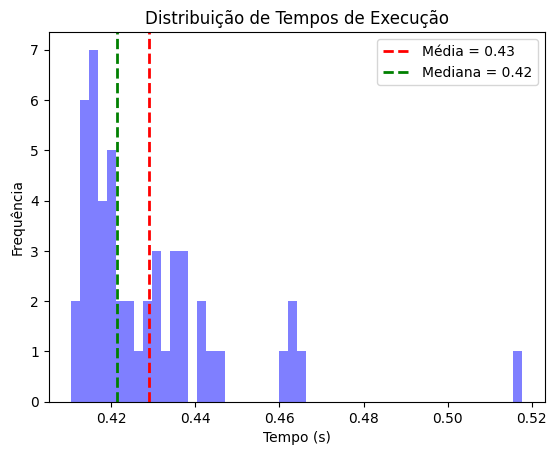

In [238]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

### Avaliação

In [239]:
trec_eval = load("trec_eval")

In [240]:
### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")
results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


   query  q0     docid  rank     score    system
0     44  Q0  cenc2u15     1  9.595705  Pesquisa
1     44  Q0  9zjtwp19     2  9.218919  Pesquisa
2     44  Q0  vgtc0k3a     3  9.138041  Pesquisa
3     44  Q0  1ogglaa3     4  8.957155  Pesquisa
4     44  Q0  nd5xpk0t     5  8.828953  Pesquisa

[5 rows x 6 columns]
NDCG@10: 0.5569450498054185
Resultados: {'runid': 'Pesquisa', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 8796, 'num_q': 50, 'map': 0.1607514087489604, 'gm_map': 0.09456175417922583, 'bpref': 0.31739196218798343, 'Rprec': 0.25396450726221553, 'recip_rank': 0.7945238095238095, 'P@5': 0.612, 'P@10': 0.588, 'P@15': 0.5613333333333334, 'P@20': 0.5489999999999999, 'P@30': 0.5293333333333333, 'P@100': 0.4232, 'P@200': 0.3518, 'P@500': 0.24971999999999997, 'P@1000': 0.17592, 'NDCG@5': 0.5866948850417006, 'NDCG@10': 0.5569450498054185, 'NDCG@15': 0.5301038903139429, 'NDCG@20': 0.5165360796843828, 'NDCG@30': 0.4968598935465589, 'NDCG@100': 0.40818913082774877, 'NDCG@200': 0.350

## SPLADE V2 (max e sem expansão para query)

In [ ]:
%%time
tempo_gasto = run_all_queries_busca_exaustiva(parm_model=model,
                                    parm_tokenizer=tokenizer, 
                                    parm_dict_queries=topics,
                                    parm_corpus_expanded=corpus_expanded, 
                                    parm_lista_doc_id_passage=lista_doc_id_passage,
                                    parm_num_max_hits=1000,
                                    parm_se_query_expansion=False)

0 queries completadas
5 queries completadas
10 queries completadas
15 queries completadas
20 queries completadas
25 queries completadas
30 queries completadas
35 queries completadas
40 queries completadas
45 queries completadas
CPU times: user 1min 50s, sys: 1.13 s, total: 1min 51s
Wall time: 21.6 s


In [242]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.4535157
std       0.0249504
min       0.4248724
25%       0.4307245
50%       0.4407955
75%       0.4805880
max       0.4980636
Name: tempo_gasto, Length: 8, dtype: float64

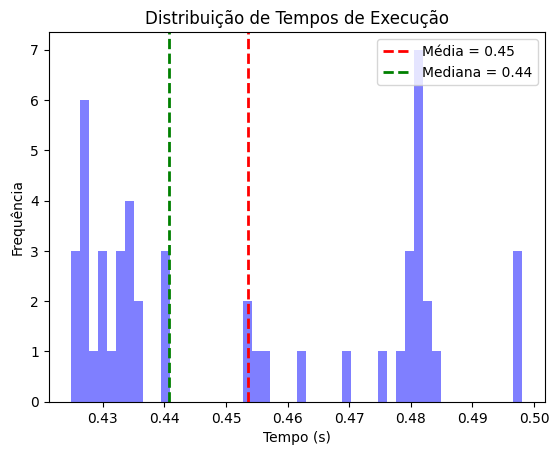

In [243]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

### Avaliação

In [244]:
trec_eval = load("trec_eval")

In [245]:
### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")
results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


   query  q0     docid  rank      score    system
0     44  Q0  dt2pew66     1  24.055389  Pesquisa
1     44  Q0  xfjexm5b     2  23.631659  Pesquisa
2     44  Q0  uc37poce     3  23.174759  Pesquisa
3     44  Q0  qi1henyy     4  23.142399  Pesquisa
4     44  Q0  28utunid     5  22.774845  Pesquisa

[5 rows x 6 columns]
NDCG@10: 0.7273549342638757
Resultados: {'runid': 'Pesquisa', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 11272, 'num_q': 50, 'map': 0.24291340206093529, 'gm_map': 0.19607936040556906, 'bpref': 0.4018979572216081, 'Rprec': 0.33779669053277495, 'recip_rank': 0.9066666666666666, 'P@5': 0.8319999999999999, 'P@10': 0.7959999999999999, 'P@15': 0.7533333333333333, 'P@20': 0.738, 'P@30': 0.708, 'P@100': 0.5680000000000001, 'P@200': 0.47680000000000006, 'P@500': 0.33063999999999993, 'P@1000': 0.22543999999999997, 'NDCG@5': 0.7498872531565653, 'NDCG@10': 0.7273549342638757, 'NDCG@15': 0.7014248590932509, 'NDCG@20': 0.6874989230317395, 'NDCG@30': 0.6642314491344944, 'NDCG@